In [26]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [27]:
def ISOdate(date):
    return pd.Timestamp(date).strftime('%Y-%m-%d')
    
def cleanup_frame(df):
    df.columns=itertools.chain(map(str.lower,df.columns[:4]),map(ISOdate,df.columns[4:]))
    return df.rename(columns={'province/state':'state','country/region':'country'}).groupby('country').sum().drop(columns=['lat','long'])

def cleanup_frame_US(kind,df):
    date_start_column=11
    drop_columns=['uid', 'iso2', 'iso3', 'code3', 'fips', 'admin2','lat','long','combined_key']
    if kind == 'deaths':
        date_start_column+=1
        drop_columns.append('population')
    df.columns=itertools.chain(map(str.lower,df.columns[:date_start_column]),map(ISOdate,df.columns[date_start_column:]))
    return df.rename(columns={'province_state':'state','country_region':'country','long_':'long'}).drop(columns=drop_columns).groupby('state').sum()

In [28]:
data={}
for df_name in ('confirmed','deaths','recovered'):
    data[df_name]=cleanup_frame(pd.read_csv(f'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{df_name}_global.csv'))
    if df_name != 'recovered':
        data[df_name+'_US']=cleanup_frame_US(df_name,pd.read_csv(f'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{df_name}_US.csv'))

In [29]:
data['infections']=data['confirmed'].sub(data['recovered'].add(data['deaths']))
data['infections_US']=data['confirmed_US'].sub(data['deaths_US'])

In [30]:
keys=list(data.keys()) # Prevent keys from changing when we add items to dictionary in for loop
for key in keys:
    data[key+'_c14davg']=data[key].rolling(window=14,axis='columns',min_periods=1).mean()

In [31]:
def chart(kind,countries,file=None):
    plt.figure()
    plt.suptitle(kind)
    if isinstance(countries,list):
        for country in countries:
            data[kind].loc[country].plot()
        plt.legend(loc='upper left')
    else:
        data[kind].loc[countries].plot()
    if file:
        plt.savefig(file)
    else:
        plt.show()



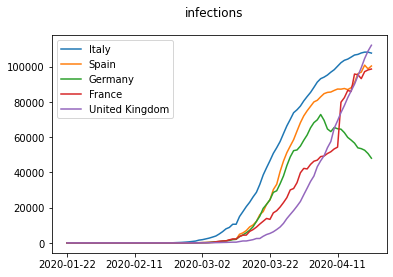

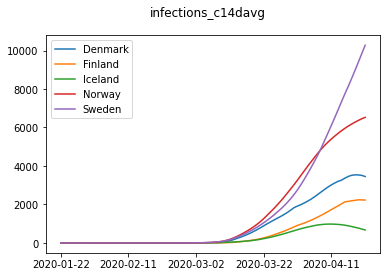

In [40]:
chart('infections',['Italy','Spain','Germany','France','United Kingdom'])
chart('infections_c14davg',['Denmark','Finland','Iceland','Norway','Sweden'])

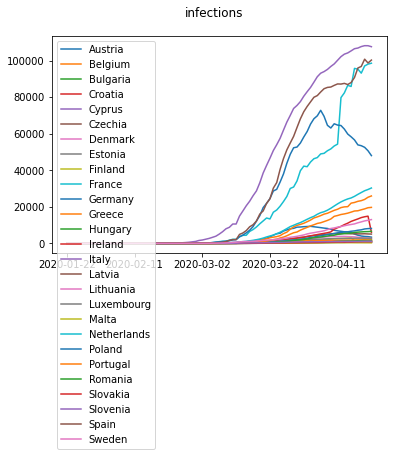

In [33]:
EU_countries=["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"]
chart('infections',EU_countries)

In [34]:
import datetime
yesterday=datetime.date.today()-datetime.timedelta(days=1) # We probably don't have today's results
def sort_countries(kind,countries):
    return sorted(countries, key=lambda x:data[kind].at[x,yesterday.isoformat()],reverse=True)

In [35]:
def topchart(kind,count=10,file=None):
    chart(kind,sort_countries(kind,data[kind].index)[:count],file=file)

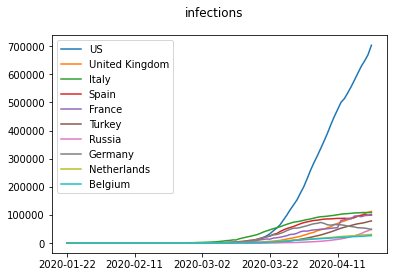

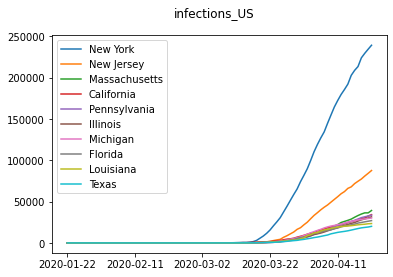

In [36]:
topchart('infections',file='infections.svg')
topchart('infections_US',file='infections_US.svg')


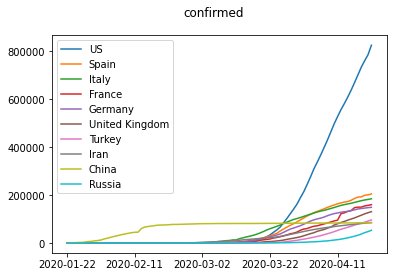

In [37]:
topchart('confirmed',file='confirmed.png')

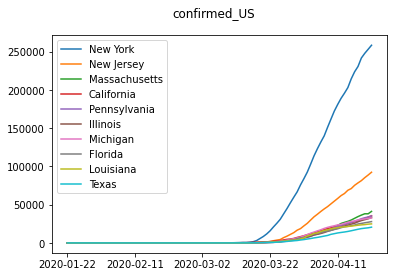

In [38]:
topchart('confirmed_US')

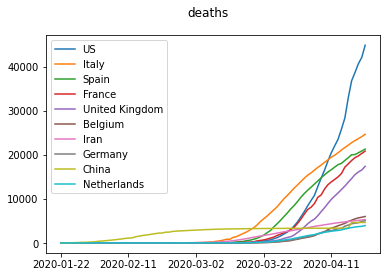

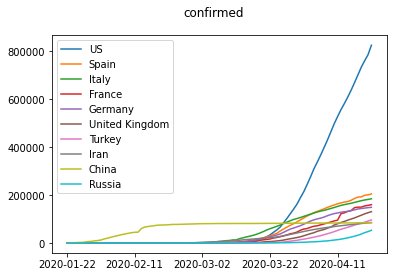

In [39]:
topchart('deaths',file='deaths.png')
topchart('confirmed',file='confirmed.png')